In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans


In [2]:
df_load = pd.read_table('/content/drive/MyDrive/Data OmicsLogic/clustering_gene.txt',sep='\t',header=(0))

In [3]:
df_load # 38 samples (columns) of 999 genes : 

,id,600MPE,AU565,BT474,BT483,BT549,CAMA1,EFM192A,EFM192B,EFM192C,HCC1143,HCC1395,HCC1419,HCC1428,HCC1569,HCC1806,HCC1937,HCC1954,HCC202,HCC3153,HCC70,JIMT1,LY2,MCF10A,MCF10F,MCF12A,MCF7,MDAMB134VI,MDAMB175VII,MDAMB231,MDAMB361,MDAMB453,MX1,SKBR3,SUM1315MO2,SUM149PT,SUM225CWN,SUM229PE,SUM52PE
0,Group,Luminal,Luminal,Luminal,Luminal,Claudin-low,Luminal,Luminal,Luminal,Luminal,Basal,Claudin-low,Luminal,Luminal,Basal,Basal,Basal,Basal,Luminal,Basal,Basal,Basal,Luminal,Normal-like,Normal-like,Normal-like,Luminal,Luminal,Luminal,Claudin-low,Luminal,Luminal,Basal,Luminal,Claudin-low,Basal,Luminal,Basal,Luminal
1,ENSG00000000419,5.32,5.3,6.64,5.6,6.61,5.24,6.66,6.62,6.41,5.19,6.16,7.29,4.78,6.14,5.66,5.8,6.2,4.69,6.5,5.49,7.29,5.23,5.63,4.82,5.64,6.07,4.79,6.25,5.19,5.8,4.63,5.98,6.19,4.97,4.15,5.82,6.4,4.67
2,ENSG00000001036,6.11,4.8,4.47,4.99,6.94,5,5.11,5.42,4.58,4.74,6.03,5.47,4.32,6.16,5.89,5.37,6.01,4.72,5.17,5.96,6.35,5.02,5.31,6.37,5.24,6.29,5.81,4.16,6.56,5.91,5.19,4,5.48,4.14,5.9,5.51,5.14,6.22
3,ENSG00000001084,5.78,4.01,5.14,5.11,3.63,5.93,4.11,3.68,3.23,5.01,5.81,4.5,5.17,5.61,6.19,5.02,6.79,5.97,4.77,5.85,4.78,4.27,6.8,6.25,4.5,5.08,5.21,4.24,4.12,6,4.16,3.19,4.29,3.95,5.26,6.63,4.38,6.38
4,ENSG00000001497,4.93,6.16,5.36,5.1,6.16,5.5,6.1,6.88,5.99,6.69,5.03,5.33,6.46,4.99,5.49,5.47,5.95,4.04,4.63,4.97,6.12,4.77,5.31,4.79,5.62,5.11,5.34,4.2,5.47,3.92,5.14,5.95,4.74,4.95,5.26,4.69,6.16,5.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ENSG00000100441,4.61,5.18,5.09,3.72,3.57,2.32,5.24,5.56,5.75,4.23,4.13,4.99,4.08,4.52,3.95,4.57,4.19,4.54,4.49,4.56,3.8,5.6,4.62,4.87,4.59,4.95,4.73,4.82,4.28,5.29,4.48,5.32,1.23,5.49,4.56,5.63,4.79,4.82
996,ENSG00000100442,6.2,4.71,6.5,5.59,4.16,5.73,5.26,5.23,4.93,4.89,4.99,3.96,5.14,3.22,4.22,4.1,5.28,4.15,6.2,4.68,5.48,5.1,4.82,4.18,4.95,5.6,5.57,5.94,5.31,6,5.57,4.58,4.31,4.49,3.79,5.21,5.1,4.96
997,ENSG00000100445,4.9,6.64,4.9,5.21,5.21,4.67,6.51,6.61,6.73,4.18,4.06,4.79,5.35,5.24,3.89,5.7,5.63,5.17,5.96,5.19,3.98,6.17,5.32,5.85,5.09,5.52,5.05,4.94,5.59,4.79,6.21,6.44,6.78,6.22,5.95,6.27,5.94,6.36
998,ENSG00000100461,5.4,6.18,6.13,5.68,4.78,5.78,6.75,6.87,6.95,5.34,6.07,5.96,5.01,4.73,5.28,6.23,5.89,5.71,5.71,5.95,5.57,6.66,5.44,5.17,5.32,5.77,5.43,5.56,5.62,5.7,5.67,6.41,5.51,5,5.95,5.73,6.12,5.76


In [4]:
#pre processing 
labels_list = df_load.loc[[0]] #we extract labels contained in 'Group'
sample_names = list(df_load)[1:] #list of labels
labels = np.unique(labels_list)
labels = np.delete(labels, np.where(labels == 'Group')) #list of unique labels
geneids = df_load['id']
geneids = geneids.drop([0]) #genes names list
data=df_load.drop([0])
df_clust = data
df_clust.set_index(['id'], inplace=True)
datafinal = data.astype(float)

In [5]:
datafinal

,600MPE,AU565,BT474,BT483,BT549,CAMA1,EFM192A,EFM192B,EFM192C,HCC1143,HCC1395,HCC1419,HCC1428,HCC1569,HCC1806,HCC1937,HCC1954,HCC202,HCC3153,HCC70,JIMT1,LY2,MCF10A,MCF10F,MCF12A,MCF7,MDAMB134VI,MDAMB175VII,MDAMB231,MDAMB361,MDAMB453,MX1,SKBR3,SUM1315MO2,SUM149PT,SUM225CWN,SUM229PE,SUM52PE
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,5.32,5.30,6.64,5.60,6.61,5.24,6.66,6.62,6.41,5.19,6.16,7.29,4.78,6.14,5.66,5.80,6.20,4.69,6.50,5.49,7.29,5.23,5.63,4.82,5.64,6.07,4.79,6.25,5.19,5.80,4.63,5.98,6.19,4.97,4.15,5.82,6.40,4.67
ENSG00000001036,6.11,4.80,4.47,4.99,6.94,5.00,5.11,5.42,4.58,4.74,6.03,5.47,4.32,6.16,5.89,5.37,6.01,4.72,5.17,5.96,6.35,5.02,5.31,6.37,5.24,6.29,5.81,4.16,6.56,5.91,5.19,4.00,5.48,4.14,5.90,5.51,5.14,6.22
ENSG00000001084,5.78,4.01,5.14,5.11,3.63,5.93,4.11,3.68,3.23,5.01,5.81,4.50,5.17,5.61,6.19,5.02,6.79,5.97,4.77,5.85,4.78,4.27,6.80,6.25,4.50,5.08,5.21,4.24,4.12,6.00,4.16,3.19,4.29,3.95,5.26,6.63,4.38,6.38
ENSG00000001497,4.93,6.16,5.36,5.10,6.16,5.50,6.10,6.88,5.99,6.69,5.03,5.33,6.46,4.99,5.49,5.47,5.95,4.04,4.63,4.97,6.12,4.77,5.31,4.79,5.62,5.11,5.34,4.20,5.47,3.92,5.14,5.95,4.74,4.95,5.26,4.69,6.16,5.11
ENSG00000001617,4.06,7.53,4.70,6.69,3.30,5.39,6.55,6.41,5.26,1.76,3.94,4.74,4.67,2.71,3.33,5.04,5.33,5.50,5.05,5.83,3.86,7.31,5.13,5.15,5.23,5.51,6.76,5.12,1.12,5.49,7.74,1.38,6.81,1.71,4.80,3.80,5.59,5.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000100441,4.61,5.18,5.09,3.72,3.57,2.32,5.24,5.56,5.75,4.23,4.13,4.99,4.08,4.52,3.95,4.57,4.19,4.54,4.49,4.56,3.80,5.60,4.62,4.87,4.59,4.95,4.73,4.82,4.28,5.29,4.48,5.32,1.23,5.49,4.56,5.63,4.79,4.82
ENSG00000100442,6.20,4.71,6.50,5.59,4.16,5.73,5.26,5.23,4.93,4.89,4.99,3.96,5.14,3.22,4.22,4.10,5.28,4.15,6.20,4.68,5.48,5.10,4.82,4.18,4.95,5.60,5.57,5.94,5.31,6.00,5.57,4.58,4.31,4.49,3.79,5.21,5.10,4.96
ENSG00000100445,4.90,6.64,4.90,5.21,5.21,4.67,6.51,6.61,6.73,4.18,4.06,4.79,5.35,5.24,3.89,5.70,5.63,5.17,5.96,5.19,3.98,6.17,5.32,5.85,5.09,5.52,5.05,4.94,5.59,4.79,6.21,6.44,6.78,6.22,5.95,6.27,5.94,6.36


[]

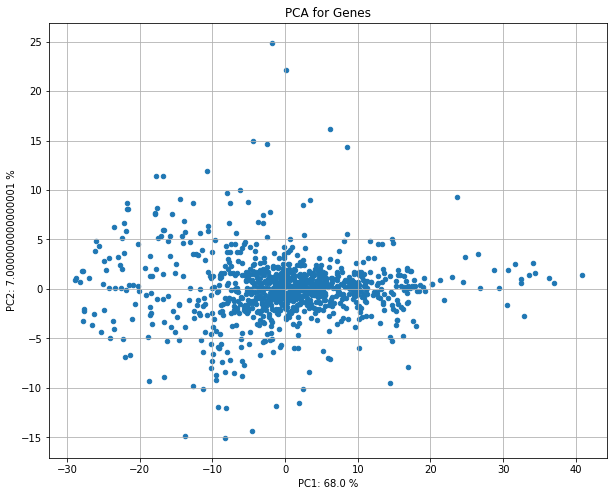

In [6]:
#prepare a scatterplot of genes based on PC1 and PC2
#the objective of the pca is to prepare a 2D-marker which contains as much information as possible about genes. 
#Later, we will use that representation for plotting the clustering results.

PC1 = 0
PC2 = 1
pca= PCA(n_components=2)
pca_all= pca.fit(datafinal)
X_pca = pca_all.transform(datafinal)

d = {'GeneIds':geneids, 'PC1':X_pca[:,PC1], 'PC2':X_pca[:,PC2]} #geneids refers to the gene name, X_pca[:,PC1] refers to that gene's x-coodinate in the 2D-marker created by pca. Same thing for X_pca[:,PC2].
df = pd.DataFrame(d)

#2D-plot of genes in the pca system.
df.plot.scatter(x='PC1', y='PC2', figsize=(10,8), title='PCA for Genes',sharex=False, grid=True).set()
plt.xlabel(f'PC1: {round(pca.explained_variance_ratio_[0],2)*100} %') 
plt.ylabel(f'PC2: {round(pca.explained_variance_ratio_[1],2)*100} %') 
plt.plot()

#Results analysis: we can notice that a great part of information (68%) is contained in the x-axis. The next axis contains only 7%.

In [7]:
# Clustering
#Let's try a clustering with 6 clusters.
k=6
kmeans = KMeans(k).fit(datafinal)
#Add kmeans cluster labels to a dataframe
df["Kmeans_6"] = kmeans.labels_
df.head()


,GeneIds,PC1,PC2,Kmeans_6
1,ENSG00000000419,4.503283,-0.568414,0
2,ENSG00000001036,2.524032,1.192051,0
3,ENSG00000001084,-0.166040,0.522194,0
4,ENSG00000001497,2.392444,0.476697,0
5,ENSG00000001617,-0.768421,-5.851831,0


[]

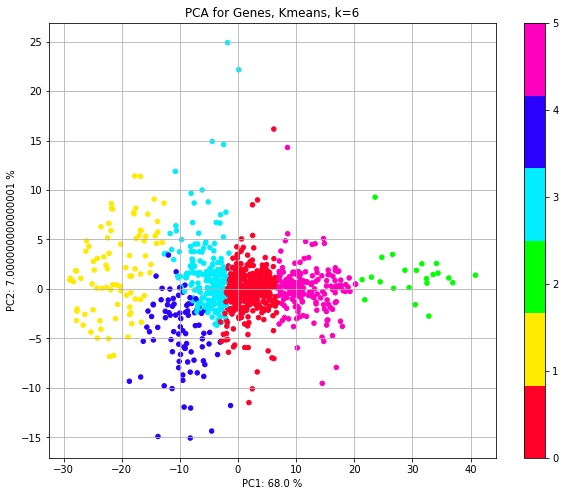

In [8]:
#Plot the 6-clusters representation
df.plot.scatter(x='PC1',y='PC2',
        c=df['Kmeans_6'], #points color depends on the point's cluster 
        colormap=plt.cm.get_cmap('gist_rainbow', k), #so that points are not in black and white shades
        figsize=(10,8),
        title='PCA for Genes, Kmeans, k=%s' % k,
        sharex=False,
        grid=True).set()
plt.xlabel(f'PC1: {round(pca.explained_variance_ratio_[0],2)*100} %') 
plt.ylabel(f'PC2: {round(pca.explained_variance_ratio_[1],2)*100} %') 
plt.plot()

#Results analysis: We observe that the clusters representation depends a lot on the x-axis. Actually, it was expected as 68% of genes information depends on that axis. 
#The y-axis contains 7% of information which explain why the points are less dependant in that axis.

In [9]:
print(kmeans.inertia_) 

56219.65294317697


In [10]:
#The next objective is to determine how many clusters we should set.
# To do so, we will represent the kmenas inertia according to the number of clusters (k).
inertia_df = pd.DataFrame()
for i in range (2,20):
  kmeans = KMeans(n_clusters=i).fit(datafinal)
  inertia_df = inertia_df.append({'clust':i,'inertia': kmeans.inertia_}, ignore_index=True)

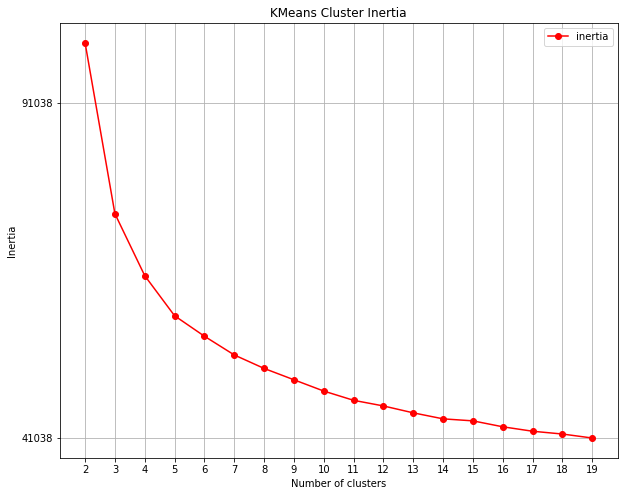

In [11]:
inertia_df.plot('clust', 'inertia', marker='o',
    figsize=(10,8), color = 'r',title='KMeans Cluster Inertia',
    sharex=False,grid=True).set(ylabel='Inertia',xlabel='Number of clusters',
xticks= np.arange(min(inertia_df.clust), max(inertia_df.clust)+1, 1.0),
yticks= np.arange(min(inertia_df.inertia), max(inertia_df.inertia)+1, 50000))
plt.show()

#Results analysis : To find the optimal k, we will find the point where the decrease in inertia begins to slow.
#Here, let's take 6.

In [12]:
# Another tool to choose the number of cluster is the silhouette score which assess the similarity between an object and its cluster.
df_scores_kmeans = pd.DataFrame()
for i in range (2,20):
      kmeans = KMeans(n_clusters=i)
      cluster_labels = kmeans.fit_predict(datafinal)
      silhouette_avg = silhouette_score(datafinal, kmeans.labels_)
      df_scores_kmeans = df_scores_kmeans.append({'clust':i,'silhouette_avg': silhouette_avg}, ignore_index=True)

[]

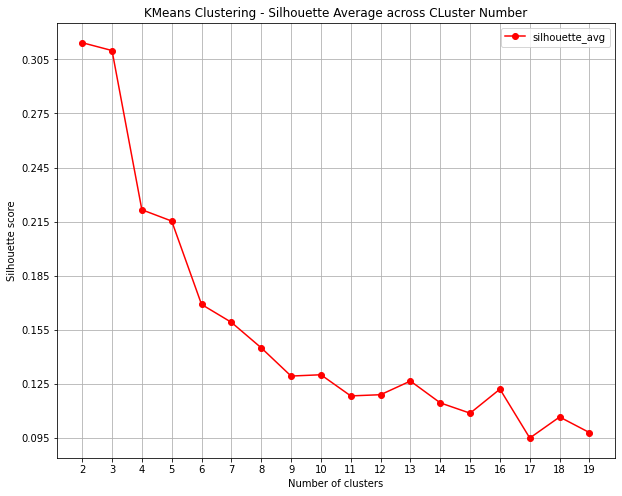

In [13]:
df_scores_kmeans.plot('clust', 'silhouette_avg', marker='o',
        figsize=(10,8), color = 'r',
        title='KMeans Clustering - Silhouette Average across CLuster Number',
        sharex=False, grid=True).set(
            ylabel='Silhouette score',xlabel='Number of clusters',
            xticks= np.arange(min(df_scores_kmeans.clust), max(df_scores_kmeans.clust)+1, 1.0),
            yticks= np.arange(min(df_scores_kmeans.silhouette_avg), max(df_scores_kmeans.silhouette_avg)+1, 0.03))
plt.plot()

# Results analysis : Similarly to intertia, we will select the k-number where the decrease in silhouette score begins to slow.
# So we choose k = 8.

In [14]:
# Scatterplot with k = 8
k=8
kmeans_m = KMeans(k).fit(datafinal)
df["Kmeans_8"] = kmeans_m.labels_
df.head()

,GeneIds,PC1,PC2,Kmeans_6,Kmeans_8
1,ENSG00000000419,4.503283,-0.568414,0,3
2,ENSG00000001036,2.524032,1.192051,0,5
3,ENSG00000001084,-0.166040,0.522194,0,2
4,ENSG00000001497,2.392444,0.476697,0,5
5,ENSG00000001617,-0.768421,-5.851831,0,5


In [15]:
print("Silhouette Coefficient for Kmeans with %s clusters: %0.3f"
      % (k, metrics.silhouette_score(datafinal, kmeans_m.labels_)))

Silhouette Coefficient for Kmeans with 8 clusters: 0.139


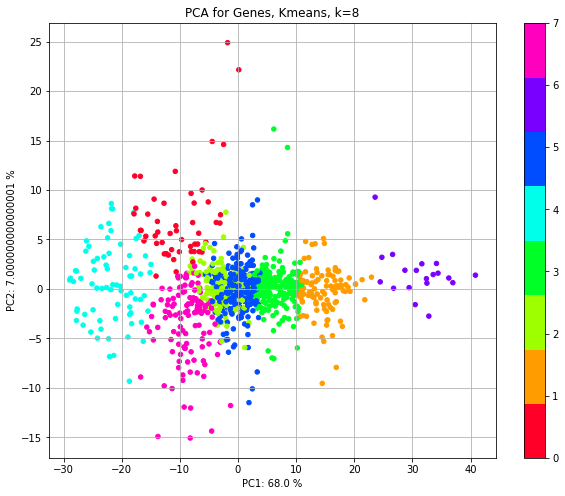

In [18]:
# Scatterplot
df.plot.scatter(x='PC1', 
                y='PC2', 
                c=df['Kmeans_8'],
                colormap=plt.cm.get_cmap('gist_rainbow', k), 
                figsize=(10,8), 
                title='PCA for Genes, Kmeans, k=%s' % k,
                sharex=False, 
                grid=True)
plt.xlabel(f'PC1: {round(pca.explained_variance_ratio_[0],2)*100} %') 
plt.ylabel(f'PC2: {round(pca.explained_variance_ratio_[1],2)*100} %') 
plt.show()

# Results analysis : The clusters breakdown still mainly depends on the x-axis, it is logical according to previous explanations.
# In addition to previous observations, we observe a distinction on the y-axis for clusters 1 and 6 according to the sign (positive or negative).

In [19]:
# Genes number breakdown in the clusters
for i in range(0, k): 
  print("cluster %s has %s genes" % (i, len(df[df['Kmeans_8'] == i])))

# The genes number is quite high. Also, some clusters don't seem to represent homogeneous clusters. 
# Indeed, we can observe "noise" and variations within clusters.
# That is why we will use DBSCAN and OPTICS methods.

cluster 0 has 51 genes
cluster 1 has 103 genes
cluster 2 has 156 genes
cluster 3 has 212 genes
cluster 4 has 74 genes
cluster 5 has 263 genes
cluster 6 has 19 genes
cluster 7 has 121 genes


In [42]:
#run DBSCAN selecting Epsilon and Min_samples according to maximum number of clusters with minimum noise
dbscan = DBSCAN(eps=3.7,min_samples=8).fit(datafinal)

# Number of clusters
print(len(set(dbscan.labels_)))

4


In [23]:
n_clusters_DB = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0) #Count of clusters (without the noisy cluster).
n_noise_DB = list(dbscan.labels_).count(-1) #Count of genes within the noisy cluster.
# Noisy samples are labelled -1.

print('Estimated number of true clusters: %d' % n_clusters_DB)
print('Estimated number of noise points: %d' % n_noise_DB)
print('Silhouette Coefficient: %0.3f'% metrics.silhouette_score(datafinal, dbscan.labels_))

Estimated number of true clusters: 3
Estimated number of noise points: 883
Silhouette Coefficient: -0.304


In [38]:
# Let's do the same thing with OPTICS
optics = OPTICS(min_samples=8, max_eps=3.7).fit(datafinal)

print(len(set(optics.labels_)))

4


In [25]:
n_clusters_OP = len(set(optics.labels_)) - (1 if -1 in optics.labels_ else 0)
n_noise_OP = list(optics.labels_).count(-1)

print('Estimated number of true clusters: %d' % n_clusters_OP)
print('Estimated number of noise points: %d' % n_noise_OP)
print('Silhouette Coefficient: %0.3f'% metrics.silhouette_score(datafinal, optics.labels_))

Estimated number of true clusters: 3
Estimated number of noise points: 895
Silhouette Coefficient: -0.318


In [27]:
# Compararison of genes belonging in the clusters for DBScan and OPTICS
d = {'GeneIds':geneids, 'Kmeans':kmeans.labels_, 'DBScan':dbscan.labels_, 'OPTICS':optics.labels_, 'PC1':X_pca[:,0], 'PC2':X_pca[:,1]}
df = pd.DataFrame(d)
df.head()

,GeneIds,Kmeans,DBScan,OPTICS,PC1,PC2
1,ENSG00000000419,11,-1,-1,4.503283,-0.568414
2,ENSG00000001036,5,-1,-1,2.524032,1.192051
3,ENSG00000001084,5,-1,-1,-0.166040,0.522194
4,ENSG00000001497,6,-1,-1,2.392444,0.476697
5,ENSG00000001617,10,-1,-1,-0.768421,-5.851831


In [28]:
print("DBSCAN clustering results show a total of %s clusters:" % n_clusters_DB)
for i in range(-1, n_clusters_DB): 
  print("cluster %s has %s genes" % (i, len(df[df['DBScan'] == i])))

print("\nOPTICS clustering results show a total of %s clusters:" % n_clusters_OP)
for i in range(-1, n_clusters_OP): 
  print("cluster %s has %s genes" % (i, len(df[df['OPTICS'] == i])))

DBSCAN clustering results show a total of 3 clusters:
cluster -1 has 883 genes
cluster 0 has 84 genes
cluster 1 has 18 genes
cluster 2 has 14 genes

OPTICS clustering results show a total of 3 clusters:
cluster -1 has 895 genes
cluster 0 has 83 genes
cluster 1 has 13 genes
cluster 2 has 8 genes


[]

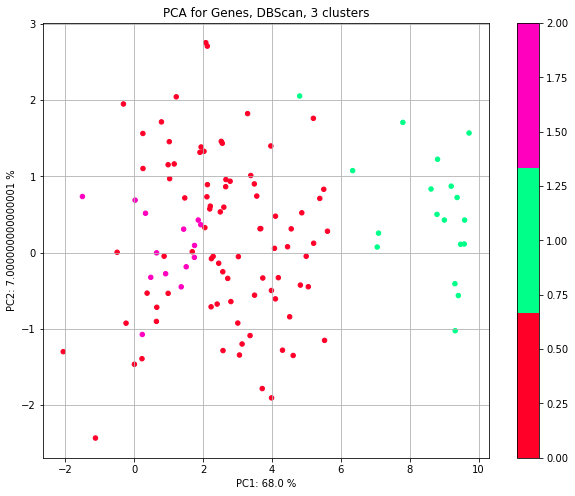

In [52]:
df2 = df[(df['DBScan'] != -1)]
df2.plot.scatter(x='PC1', 
                y='PC2', 
                c=df2['DBScan'], 
                colormap=plt.cm.get_cmap('gist_rainbow', n_clusters_DB), 
                figsize=(10,8),
                title='PCA for Genes, DBScan, %s clusters' % n_clusters_DB,
                sharex=False, 
                grid=True)
plt.xlabel(f'PC1: {round(pca.explained_variance_ratio_[0],2)*100} %') 
plt.ylabel(f'PC2: {round(pca.explained_variance_ratio_[1],2)*100} %') 
plt.plot()

#Results analysis : 
# First, although the green cluster is quite explicitly separated from the rest, the red and pink ones are intertwined.
# We can add that the DBScan method has mainly kept points around the x-axis : the scale is between y=-3 and y=3 whereas originally the
# scale was between y=-15 and y=25. 
# Also, among the x-axis, points are located between x=-2 and x=10 whereas the original scale was between x=-30 and x=40.
# Some whole clusters have beenn considered as noise.
# To conclude, that approach doesn't consider enough points. Many clusters have been considered as noise.
# However, that approach is interested as it doesn't force the definition of clusters if items are not at least minimally linked. 

[]

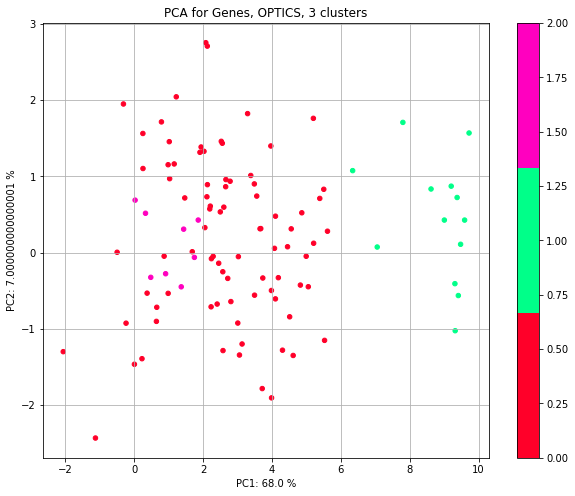

In [43]:
df3 = df[(df['OPTICS'] != -1)]
df3.plot.scatter(x='PC1', 
                y='PC2', 
                c=df3['OPTICS'], 
                colormap=plt.cm.get_cmap('gist_rainbow', n_clusters_OP), 
                figsize=(10,8),
                title='PCA for Genes, OPTICS, %s clusters' % n_clusters_OP,
                sharex=False, 
                grid=True)
plt.xlabel(f'PC1: {round(pca.explained_variance_ratio_[0],2)*100} %') 
plt.ylabel(f'PC2: {round(pca.explained_variance_ratio_[1],2)*100} %') 
plt.plot()

# Resultats analysis : Same conclusion as for DBScan. 
# We can add that that method looks more accurate: more points (especially in the pink cluster) are considered as noise.
# Also, the pink cluster looks better delimitated with OPTICS than DBScan. 
# And some noisy green points on the DBScan scatterplot are removed on the OPTICS one.
# Therefore that approach seems more precise that the DBScan one.

In [44]:
df_clust["Kmeans"] = kmeans.labels_
df_clust["DBScan"] = dbscan.labels_
df_clust["OPTICS"] = optics.labels_
df_clust.head()

,600MPE,AU565,BT474,BT483,BT549,CAMA1,EFM192A,EFM192B,EFM192C,HCC1143,HCC1395,HCC1419,HCC1428,HCC1569,HCC1806,HCC1937,HCC1954,HCC202,HCC3153,HCC70,JIMT1,LY2,MCF10A,MCF10F,MCF12A,MCF7,MDAMB134VI,MDAMB175VII,MDAMB231,MDAMB361,MDAMB453,MX1,SKBR3,SUM1315MO2,SUM149PT,SUM225CWN,SUM229PE,SUM52PE,Kmeans,DBScan,OPTICS
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,5.32,5.3,6.64,5.6,6.61,5.24,6.66,6.62,6.41,5.19,6.16,7.29,4.78,6.14,5.66,5.8,6.2,4.69,6.5,5.49,7.29,5.23,5.63,4.82,5.64,6.07,4.79,6.25,5.19,5.8,4.63,5.98,6.19,4.97,4.15,5.82,6.4,4.67,11,-1,-1
ENSG00000001036,6.11,4.8,4.47,4.99,6.94,5,5.11,5.42,4.58,4.74,6.03,5.47,4.32,6.16,5.89,5.37,6.01,4.72,5.17,5.96,6.35,5.02,5.31,6.37,5.24,6.29,5.81,4.16,6.56,5.91,5.19,4,5.48,4.14,5.9,5.51,5.14,6.22,5,-1,-1
ENSG00000001084,5.78,4.01,5.14,5.11,3.63,5.93,4.11,3.68,3.23,5.01,5.81,4.5,5.17,5.61,6.19,5.02,6.79,5.97,4.77,5.85,4.78,4.27,6.8,6.25,4.5,5.08,5.21,4.24,4.12,6,4.16,3.19,4.29,3.95,5.26,6.63,4.38,6.38,5,-1,-1
ENSG00000001497,4.93,6.16,5.36,5.1,6.16,5.5,6.1,6.88,5.99,6.69,5.03,5.33,6.46,4.99,5.49,5.47,5.95,4.04,4.63,4.97,6.12,4.77,5.31,4.79,5.62,5.11,5.34,4.2,5.47,3.92,5.14,5.95,4.74,4.95,5.26,4.69,6.16,5.11,6,-1,-1
ENSG00000001617,4.06,7.53,4.7,6.69,3.3,5.39,6.55,6.41,5.26,1.76,3.94,4.74,4.67,2.71,3.33,5.04,5.33,5.5,5.05,5.83,3.86,7.31,5.13,5.15,5.23,5.51,6.76,5.12,1.12,5.49,7.74,1.38,6.81,1.71,4.8,3.8,5.59,5.27,10,-1,-1


In [45]:
df_DBScan = df_clust.drop(['Kmeans',  'OPTICS'], axis=1)
df_DBScan = df_DBScan.astype(float)

df_Optics = df_clust.drop(['Kmeans',  'DBScan' ], axis=1)
df_Optics = df_Optics.astype(float)

df_Kmeans = df_clust.drop(['DBScan',  'OPTICS' ], axis=1)
df_Kmeans = df_Optics.astype(float)

for DBScan cluster 0, the number of genes is 84
for DBScan cluster 1, the number of genes is 18
for DBScan cluster 2, the number of genes is 14
[[2, 0.7380433405524948]]


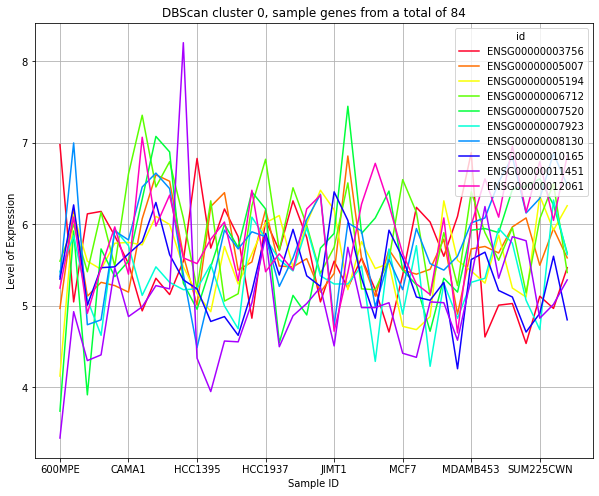

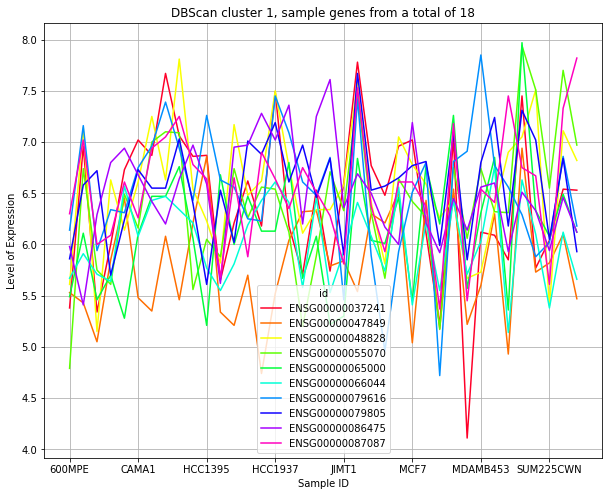

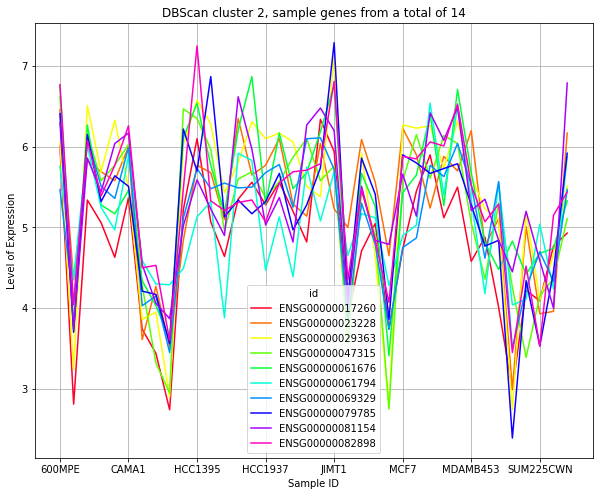

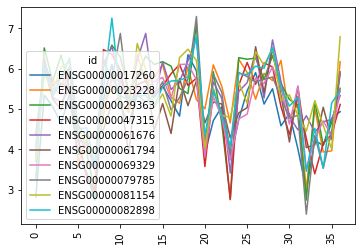

In [49]:
#create an empty list
corrlist_DB = []
#loop for DBScan clusters
for i in range(0, n_clusters_DB): 
  Clusteri = df_DBScan[df_DBScan['DBScan'] == i]
  Clusteri = Clusteri.drop(['DBScan'], axis=1)
  Clusteri.head()
  n = len(Clusteri)
  if n < 10:
      ClusteriX = Clusteri.head(5)
  else:
      ClusteriX = Clusteri.head(10)
  print("for DBScan cluster %s, the number of genes is %s" % (i, n))
  ClusteriX.T.plot(colormap='gist_rainbow', 
                  figsize=(10,8),
                  title='DBScan cluster %s, sample genes from a total of %s' % (i, n),
                  sharex=False, 
                  grid=True).set(
                      ylabel='Level of Expression',
                      xlabel='Sample ID')

corr = Clusteri.T.corr()
corrmean = corr.values[np.triu_indices_from(corr.values,1)].mean()
corrlist_DB.append([i, corrmean])

#corrlist.append([i,corrmean])
ClusteriX.iloc[:,1:38].T.plot(rot=90, use_index=False)

print(corrlist_DB)

These schemes represent the genes expression for genes within a same cluster. Indeed the goal of our study is to create clusters containing genes having similar expression patterns among samples.
Results analysis :
For clusters 0 and 1, it is quite complicated to visualy assess the genes expression similarities. However for the cluster 2, we observe same trends for genes expression. That cluster looks appropriated.